## Modeling temperature of NUC as a function of power and fan speed
We are trying to model the thermal behaviour of the NUC as per the equation: $T(t) = T_{ss} - (T_{ss} - T_0)e^{-bt}$. We will split this analysis into two stages: 

1. First we model $T_{ss}$ by filtering steady state information from all of the data collected. 
2. Using the model build for $T_{ss}$, we will fit the above exponential curve to the data and build a model for parameter $b$ 

We are modeling temperature (independent variable) as a function of power and fanspeed (dependent variables). We stress the cpu under constant values of power (via the cpu load) and fanspeed till the temperature hits the steady state and do so for a set of discrete set of [fanspeed, power] values. The data collected has both the transition to steady state (the exponential curves) and the steady state values. We split the data into two parts and model $T_{ss}$ and $b$ separately.       

In [104]:
import sys
import os 				# For splitting paths into filename and dirname
import subprocess 			# Executing bash command
import pandas as pd 			# reading csv files
from pandas.plotting import scatter_matrix
%matplotlib notebook 
import matplotlib.pylab as plt		# Plotting API's
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.dates import strpdate2num
import numpy as np
import time
import argparse
import csv
import pickle
import seaborn as sns
from datetime import timedelta

## Read in data collected from the NUC
Compute power as the rate of change of energy measured using RAPL

In [7]:
rapl_dataFile                           = '/home/raghuveer/MyFiles/LearningOS_GIT/thermals/nuc_thermals/FanControl/data/power/sensorData_Oct_10_2017_16_03_20.txt' 
rawData4                                = pd.read_csv(rapl_dataFile)
rawData4['Datetime']                    = pd.to_datetime(rawData4['Datetime'])
rawData4                                = rawData4.set_index('Datetime')
rawData4 = rawData4.rename(columns={'it8603_fan_2': 'Fanspeed', 'coretemp_temp_Core_0' : 'CoreTemperature'})
Data4    = rawData4.resample('1s').mean().interpolate()
Data4['power']          = 0.001*(Data4['cpu_raplenergy'].diff() / Data4['cpu_raplenergy'].index.to_series().diff().dt.total_seconds()) #.rolling(window=gradientwindowsize, center=False).mean()

## Filter $T_{ss}$ data collected at the start and end of applying stress-ng: temperature, power and fanspeed at steady state:

In [342]:
data = np.loadtxt('/home/raghuveer/MyFiles/LearningOS_GIT/thermals/nuc_thermals/FanControl/data/power/timing.log',dtype='str')
myarr2 = np.zeros(shape=(data.shape[0],3))

count = 0
for line in data:
    mytime = str(line[0]) + ' ' + str(line[1])
    myarr2[count] = [Data4.loc[mytime,'CoreTemperature'].mean(), Data4.loc[mytime,'Fanspeed'].mean(), Data4.loc[mytime,'power'].mean()]
    count = count + 1

<IPython.core.display.Javascript object>


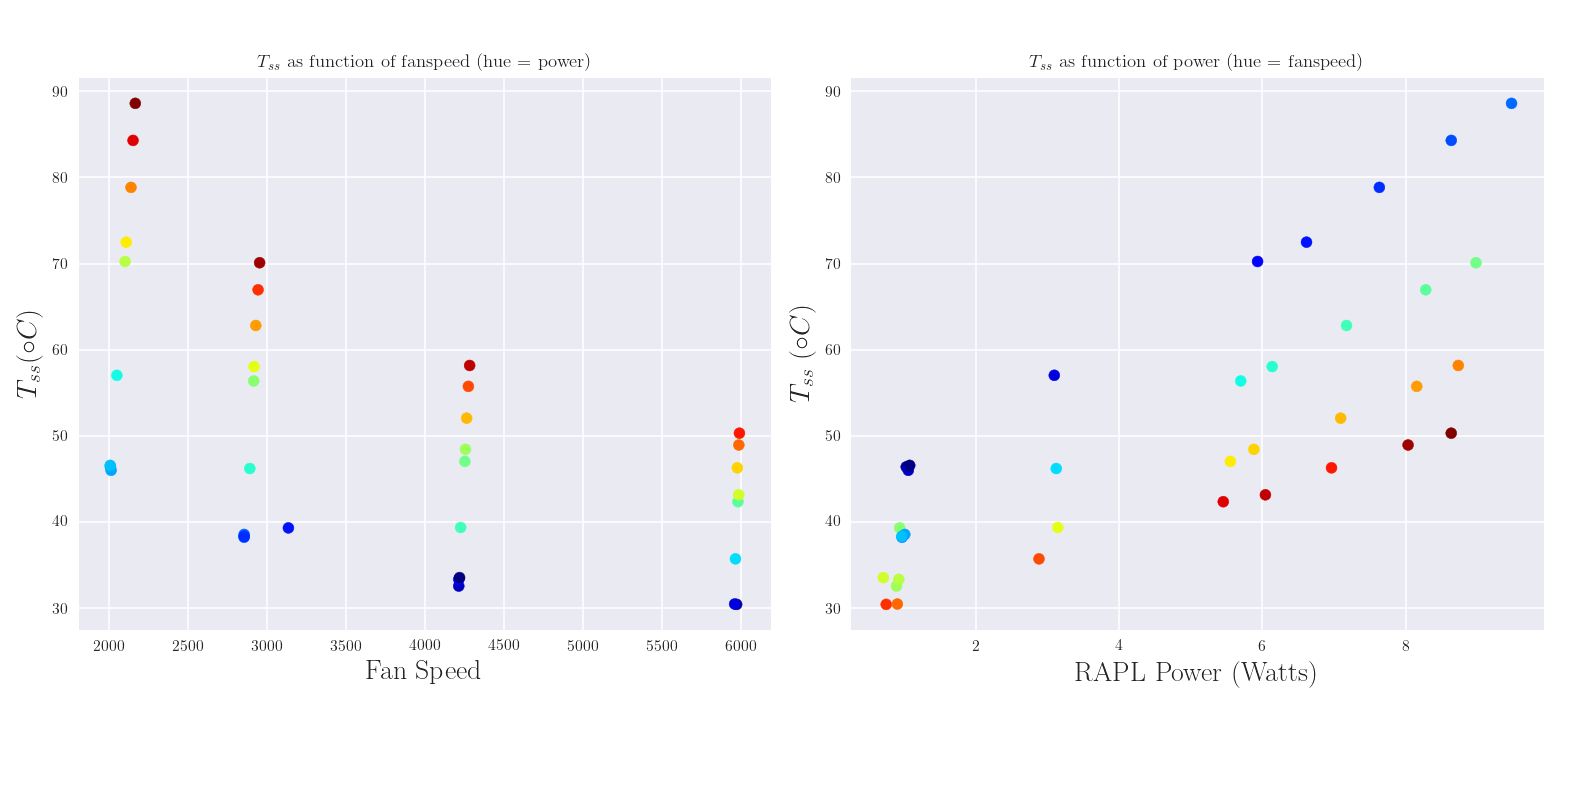

In [362]:
def GetColorsCloumn(temp):
    Array = np.array(temp)
    categories = np.unique(Array) 
    colors = plt.cm.jet(np.linspace(0,1,len(categories)))
    colordict = dict(zip(categories, colors))  
    color = []
    for elem in temp:
        color.append(colordict[elem])
    return color 

SteadyStateData = pd.DataFrame(myarr2, columns=['coretemperature', 'fanspeed', 'power'])
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(SteadyStateData['fanspeed'], SteadyStateData['coretemperature'], c=GetColorsCloumn(SteadyStateData['power']))
plt.xlabel('Fan Speed', fontsize=18)
plt.ylabel('$T_{ss} (\circ C)$', fontsize=18)
plt.title('$T_{ss}$ as function of fanspeed (hue = power)')
plt.subplot(122)
plt.scatter(SteadyStateData['power'], SteadyStateData['coretemperature'], c=GetColorsCloumn(SteadyStateData['fanspeed']))
plt.xlabel('RAPL Power (Watts)', fontsize=18)
plt.ylabel('$T_{ss}$ $(\circ C)$', fontsize=18)
plt.tight_layout()
plt.title('$T_{ss}$ as function of power (hue = fanspeed)')
plt.subplots_adjust(left=0.05, right=0.98, top=0.90, bottom=0.2)

## Model for $T_{ss}$  using polynomial fit: 

In [334]:
X_train = SteadyStateData[['fanspeed','power']] 
Y_train = SteadyStateData['coretemperature']
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
# ---> works polymodel = make_pipeline(PolynomialFeatures(3), Lasso(alpha=0.00005, normalize=False, max_iter=10000000))
polymodel = make_pipeline(PolynomialFeatures(3), Lasso(alpha=0.00005, normalize=False, max_iter=10000000))
polymodel.fit(np.array(X_train), np.array(Y_train))
print("RMSE = ", mean_squared_error(Y_train, polymodel.predict(X_train)))
pickle.dump(polymodel, open('Tss_PowerModel_polyRegr.sav', 'wb'))

RMSE =  0.426292909078


## Visualize the model by drawing level sets $T_{ss}$ as a function of fanspeed and power
The model seems to be slighlty overfitting (specially for fanspeed $\in [4000,6000]$), which can be resolved fixed by collecting data at fanspeed of 5000, but we won't worry about it for now.

<IPython.core.display.Javascript object>


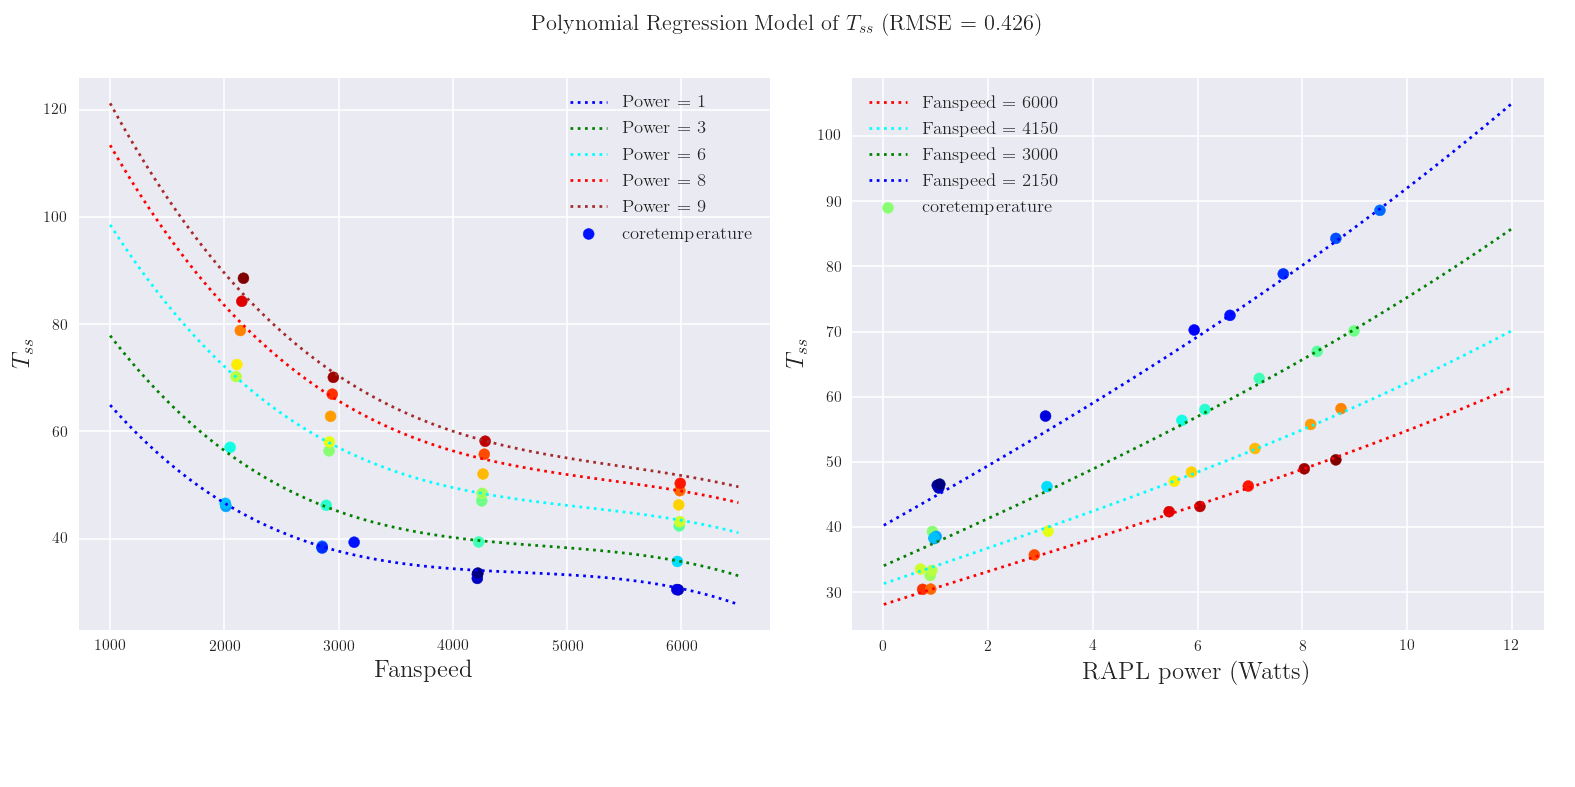

In [361]:
def PredictionAnalysis(XTrain, YTrain, model, title, power_mean=0, power_std=1, fan_mean=0, fan_std=1):
    fanspeed_test = np.linspace(1000,6500,100)
    power_test = np.linspace(0.01,12,100)
    plt.figure(figsize=(14,7))
    plt.subplot(121)
    plt.scatter(SteadyStateData['fanspeed'], SteadyStateData['coretemperature'], c=GetColorsCloumn(SteadyStateData['power']))
    plt.plot(fanspeed_test, model.predict(np.vstack((fanspeed_test, (np.linspace(1,1,100) - power_mean)/power_std)).T), linestyle=':', color='blue',  label='Power = 1') 
    plt.plot(fanspeed_test, model.predict(np.vstack((fanspeed_test, (np.linspace(3,3,100) - power_mean)/power_std)).T), linestyle=':', color='green', label='Power = 3') 
    plt.plot(fanspeed_test, model.predict(np.vstack((fanspeed_test, (np.linspace(6,6,100) - power_mean)/power_std)).T), linestyle=':', color='cyan',label='Power = 6') 
    plt.plot(fanspeed_test, model.predict(np.vstack((fanspeed_test, (np.linspace(8,8,100) - power_mean)/power_std)).T), linestyle=':', color='red', label='Power = 8') 
    plt.plot(fanspeed_test, model.predict(np.vstack((fanspeed_test, (np.linspace(9,9,100) - power_mean)/power_std)).T), linestyle=':', color='brown', label='Power = 9') 
    plt.ylabel('$T_{ss}$', fontsize=16)
    plt.xlabel('Fanspeed', fontsize=16)
    plt.legend(prop={'size': 12})
    plt.subplot(122)
    plt.scatter(SteadyStateData['power'], SteadyStateData['coretemperature'], c=GetColorsCloumn(SteadyStateData['fanspeed']))
    plt.plot(power_test, model.predict(np.vstack(((np.linspace(6000,6000,100) - fan_mean)/fan_std, power_test)).T), color='red',    linestyle=':', label = 'Fanspeed = 6000') 
    plt.plot(power_test, model.predict(np.vstack(((np.linspace(4250,4250,100) - fan_mean)/fan_std, power_test)).T), color='cyan',   linestyle=':', label = 'Fanspeed = 4150') 
    plt.plot(power_test, model.predict(np.vstack(((np.linspace(3000,3000,100) - fan_mean)/fan_std, power_test)).T), color='green',  linestyle=':', label = 'Fanspeed = 3000') 
    plt.plot(power_test, model.predict(np.vstack(((np.linspace(2150,2150,100) - fan_mean)/fan_std, power_test)).T), color='blue',   linestyle=':', label = 'Fanspeed = 2150') 
    plt.ylabel('$T_{ss}$', fontsize=16)
    plt.xlabel('RAPL power (Watts)', fontsize=16)
    plt.legend(prop={'size': 12})
    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(left=0.05, right=0.98, top=0.90, bottom=0.2)
    plt.show()
    
PredictionAnalysis(X_train, Y_train, polymodel, 'Polynomial Regression Model of $T_{ss}$ (RMSE = 0.426)')

In [344]:
#phoronix_dataFile                       = '/home/raghuveer/MyFiles/LearningOS_GIT/thermals/nuc_thermals/FanControl/data/phoronix/sensorData_Oct_12_2017_11_18_08.txt'
#rawData5                                = pd.read_csv(phoronix_dataFile)
#rawData5['Datetime']                    = pd.to_datetime(rawData5['Datetime'])
#rawData5                                = rawData5.set_index('Datetime')
#rawData5 = rawData5.rename(columns={'it8603_fan_2': 'Fanspeed', 'coretemp_temp_Core_0' : 'CoreTemperature'})
#Data5    = rawData5.resample('1s').mean().interpolate()
#Data5['power']          = 0.001*(Data5['cpu_raplenergy'].diff() / Data5['cpu_raplenergy'].index.to_series().diff().dt.total_seconds())

## Visualzing the whole data set with the predicted $T_{ss}$

<IPython.core.display.Javascript object>


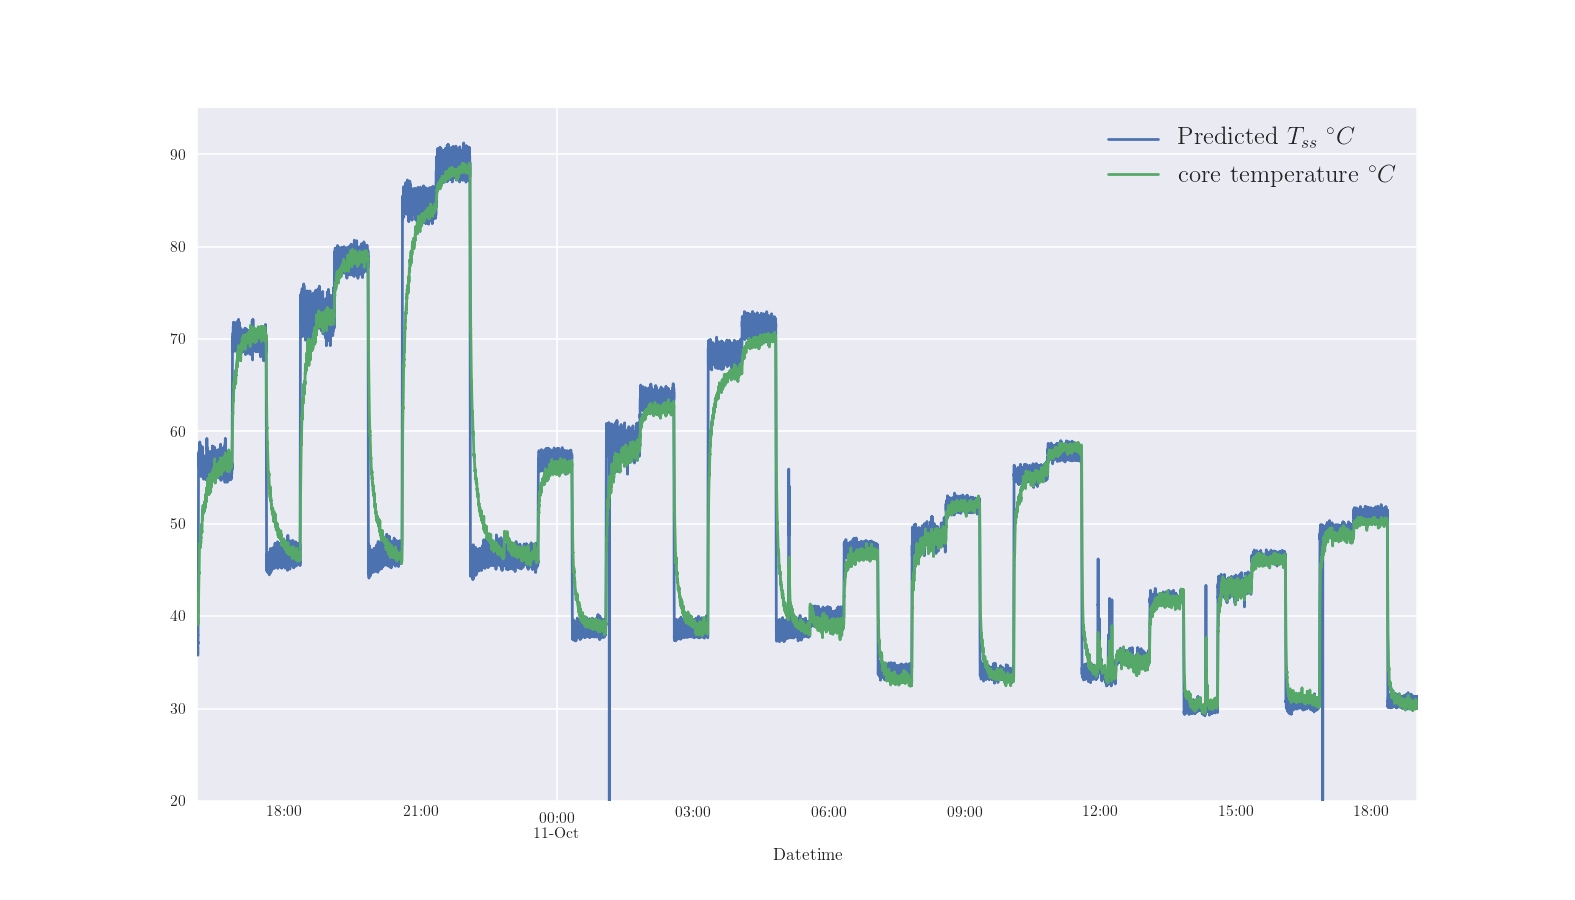

In [360]:
Data4['Tss_new'] = polymodel.predict(np.array([Data4['Fanspeed'], Data4['power'].fillna(0)]).T)
plt.figure(figsize=(14,8))
left  = '2017-10-10 16:03:30'
right = '2017-10-11 19:00:00'
Data4.loc[left:right,'Tss_new'].rolling(window=30,center=False).mean().plot(label='Predicted $T_{ss}$ $^\circ C $')
Data4.loc[left:right,'CoreTemperature'].rolling(window=30,center=False).mean().plot(label='core temperature $^\circ C$')
plt.ylim([20,95])
plt.legend(prop={'size':16})

## For every exponential curve in the data, find the best value of $b$ that fits the equation: $T(t) = T_{ss} - (T_{ss}-T_0)e^{-bt}$

In [270]:
from scipy.optimize import curve_fit
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

def computeB(df, left, ii):
    left = pd.to_datetime(left)
    right = left + timedelta(minutes=45)
    T     = np.array(df.loc[left:right, 'CoreTemperature'])
    T0    = df.loc[left - timedelta(minutes=0.5):left, 'CoreTemperature'].mean()
    Tss   = df.loc[right - timedelta(minutes=2):right, 'CoreTemperature'].mean()
    power = df.loc[right - timedelta(minutes=2):right, 'power'].mean()
    fan   = df.loc[right - timedelta(minutes=2):right, 'Fanspeed'].mean()
    n = T.shape[0]
    t = np.linspace(1,n,n)
    
    myfunc = lambda b,x: Tss - (Tss-T0) * np.exp(-b * x)
    popt, pcov = curve_fit(myfunc, t, T, p0=[0.040])
    
    return t, T, myfunc(t,*popt), float(*popt), power, fan

<IPython.core.display.Javascript object>


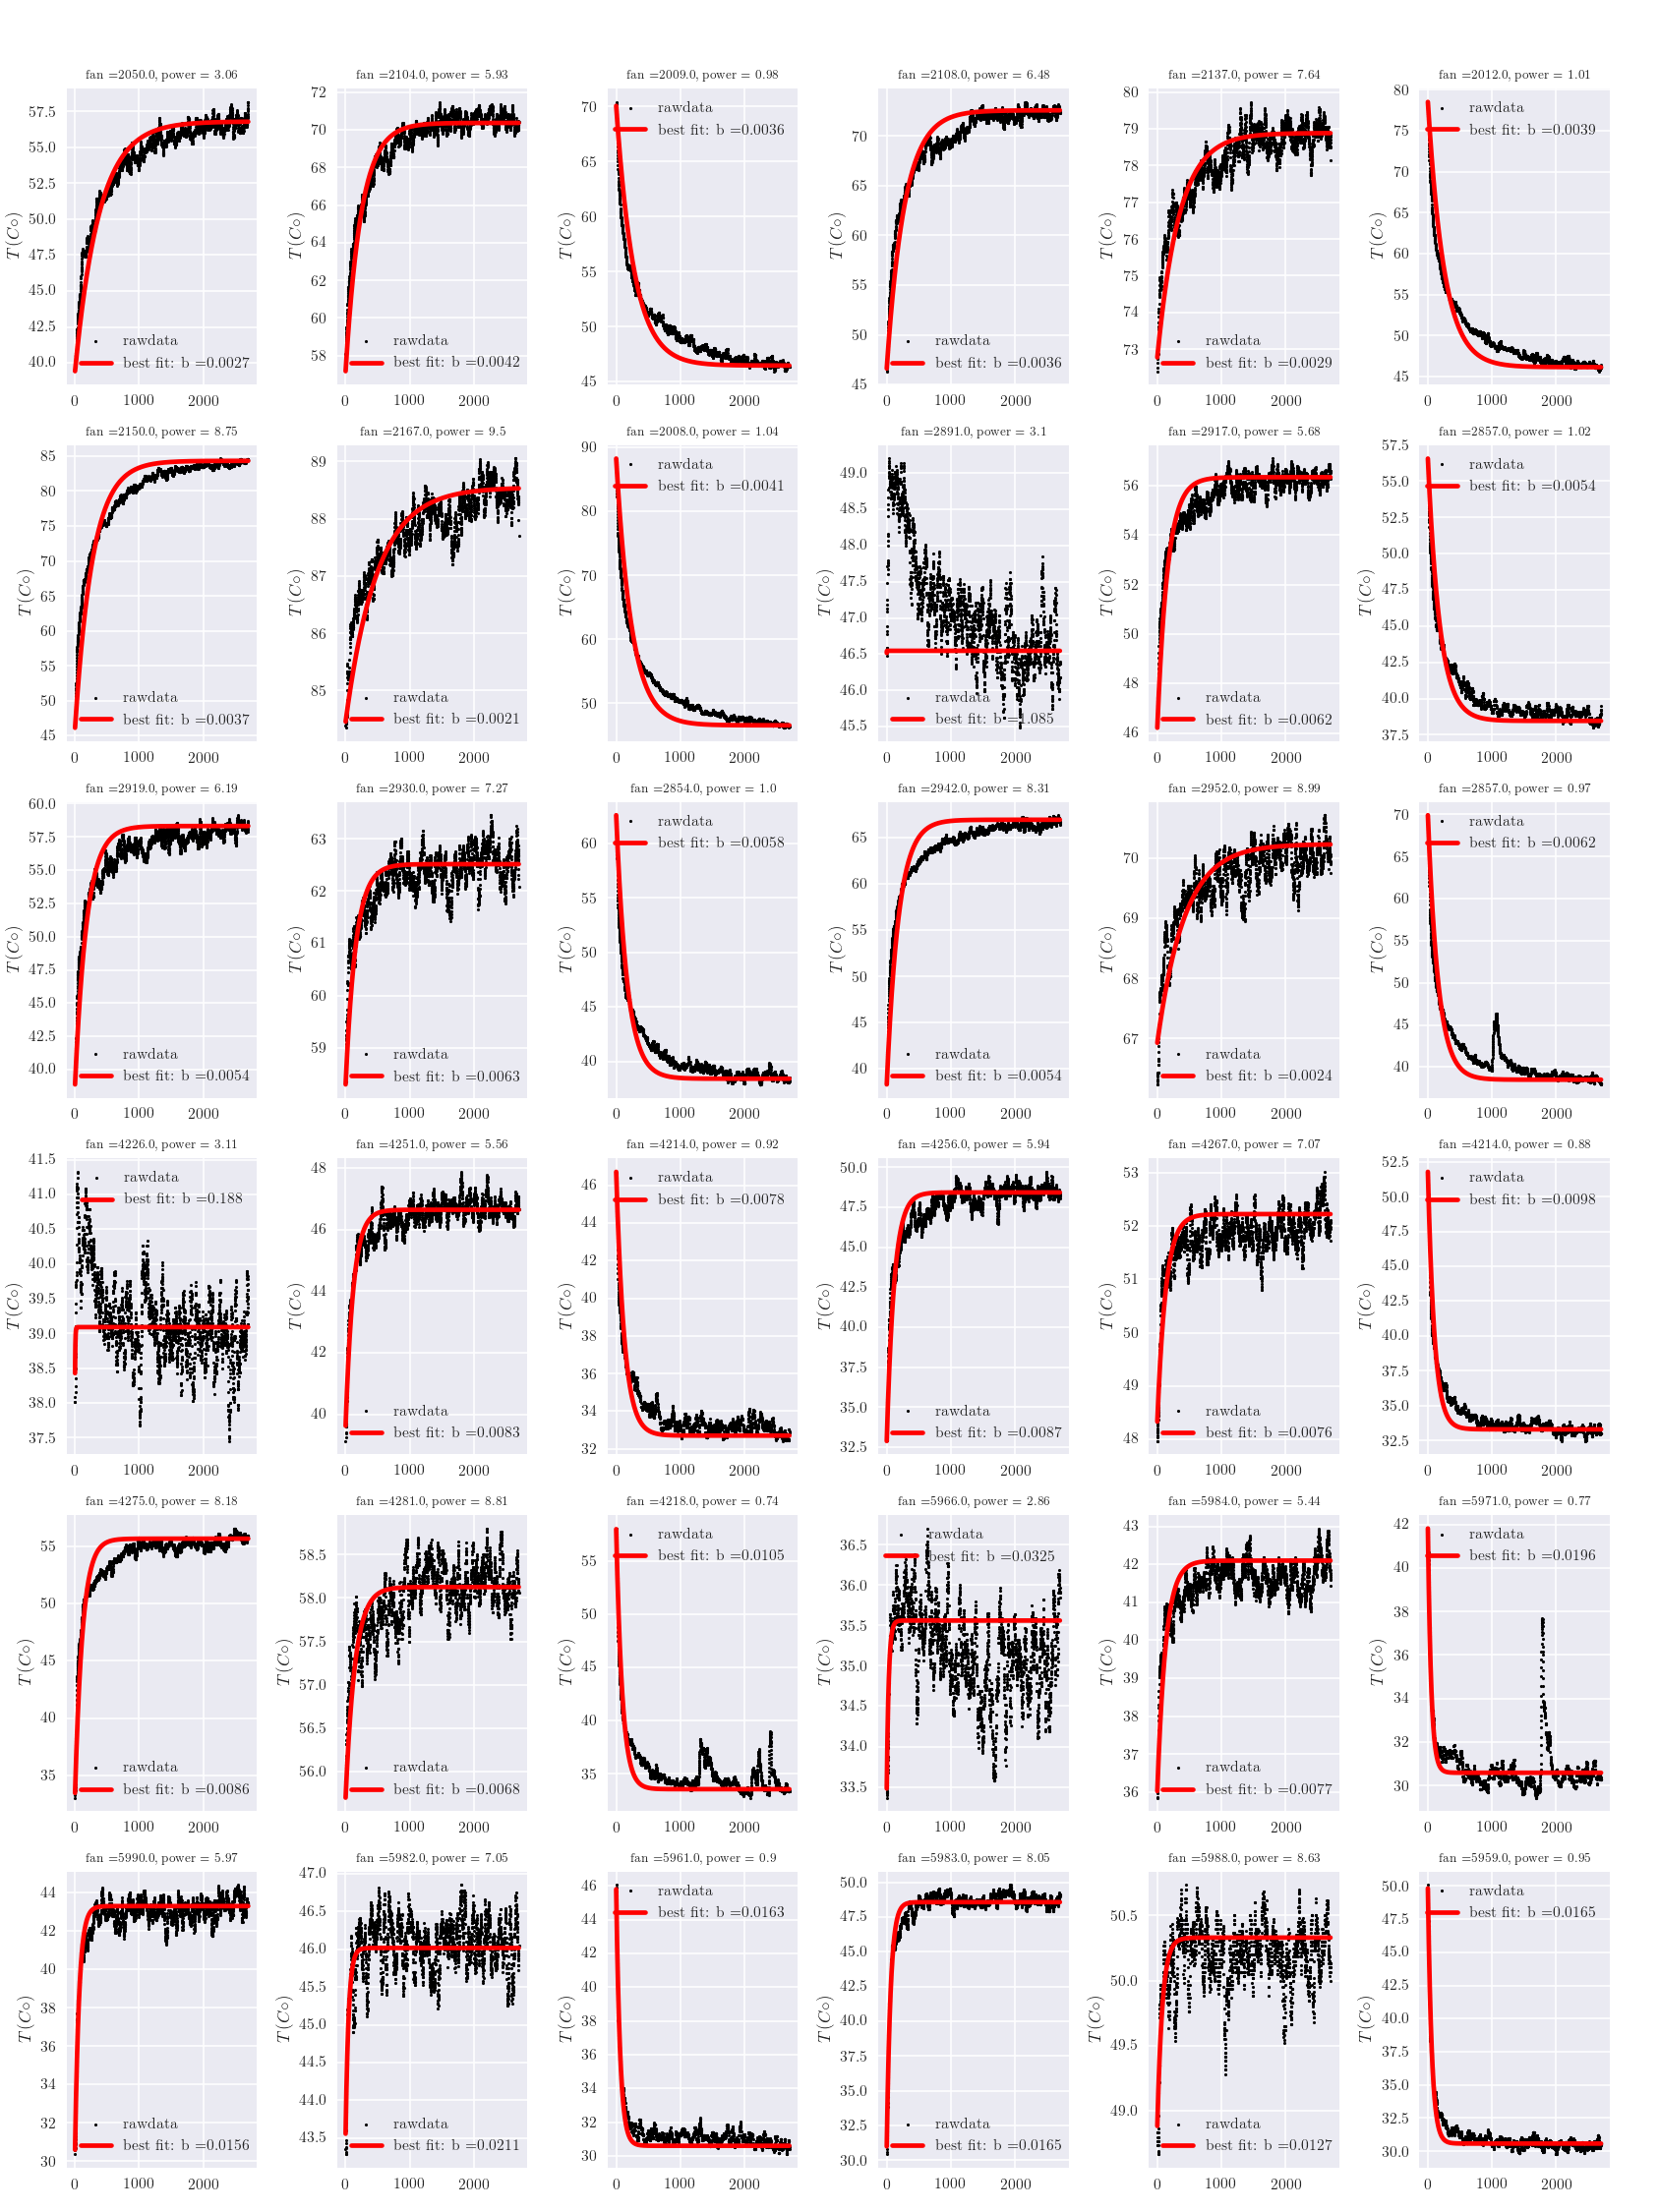

/home/raghuveer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


In [359]:
bplot = True 
df = Data4.rolling(window=30,center=False).mean()
if bplot: 
    plt.figure(figsize=(15,20))

data_for_calc_b = np.zeros((36,3))

for i in range(0,36):
    left = pd.to_datetime('2017-10-10 16:05:12') + timedelta(minutes=i*45)
    t, T, T_f, b, power, fan = computeB(df, left, i)
    data_for_calc_b[i,:] = [b, power, fan]
    if bplot: 
        plt.subplot(6,6,i+1)
        lab1 ="best fit: b =" +str(round(b,4))
        lab2 ="rawdata"
        tit = "fan =" +str(round(fan,0)) + ", power = " + str(round(power,2))
        plt.plot(t, T, 'ko', label=lab2, markersize=2)
        plt.plot(t, T_f, 'r-', label = lab1, linewidth=3)
        plt.ylabel("$T (C\circ)$")
        plt.title(tit, fontsize=8)
        plt.legend()

if bplot: 
    plt.tight_layout()
    plt.subplots_adjust(left=0.04, right=0.97, top=0.96, bottom=0.02)

## Plot $b$ as a function of fanspeed and power
It doesn't seem like it depends on power (which is odd), so for now we will approximate $b$ with just fan speed

<IPython.core.display.Javascript object>


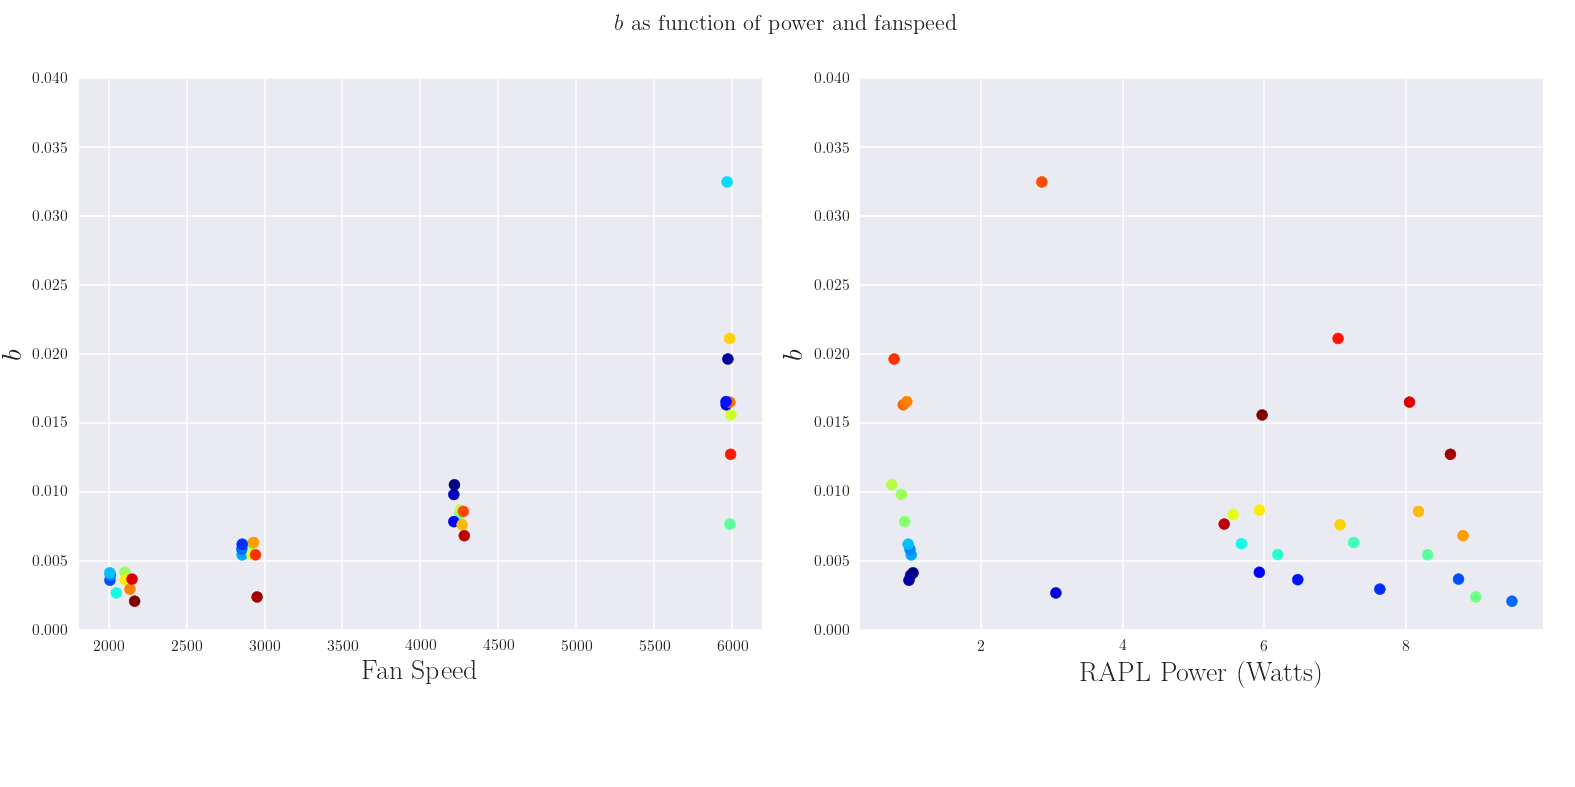

In [357]:
pdData = pd.DataFrame(data_for_calc_b, columns=['b','power','fanspeed'])
pdCleanedData = pdData[pdData['b'] < 0.025]
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(pdData['fanspeed'], pdData['b'], c=GetColorsCloumn(pdData['power']))
plt.xlabel('Fan Speed', fontsize=18)
plt.ylabel('$b$', fontsize=18)
plt.ylim([0,0.04])
plt.subplot(122)
plt.scatter(pdData['power'], pdData['b'], c=GetColorsCloumn(pdData['fanspeed']))
plt.ylim([0,0.04])
plt.xlabel('RAPL Power (Watts)', fontsize=18)
plt.ylabel('$b$', fontsize=18)
plt.tight_layout()
plt.suptitle('$b$ as function of power and fanspeed')
plt.subplots_adjust(left=0.05, right=0.98, top=0.90, bottom=0.2)

RMSE:  4.56834863049e-06


<IPython.core.display.Javascript object>


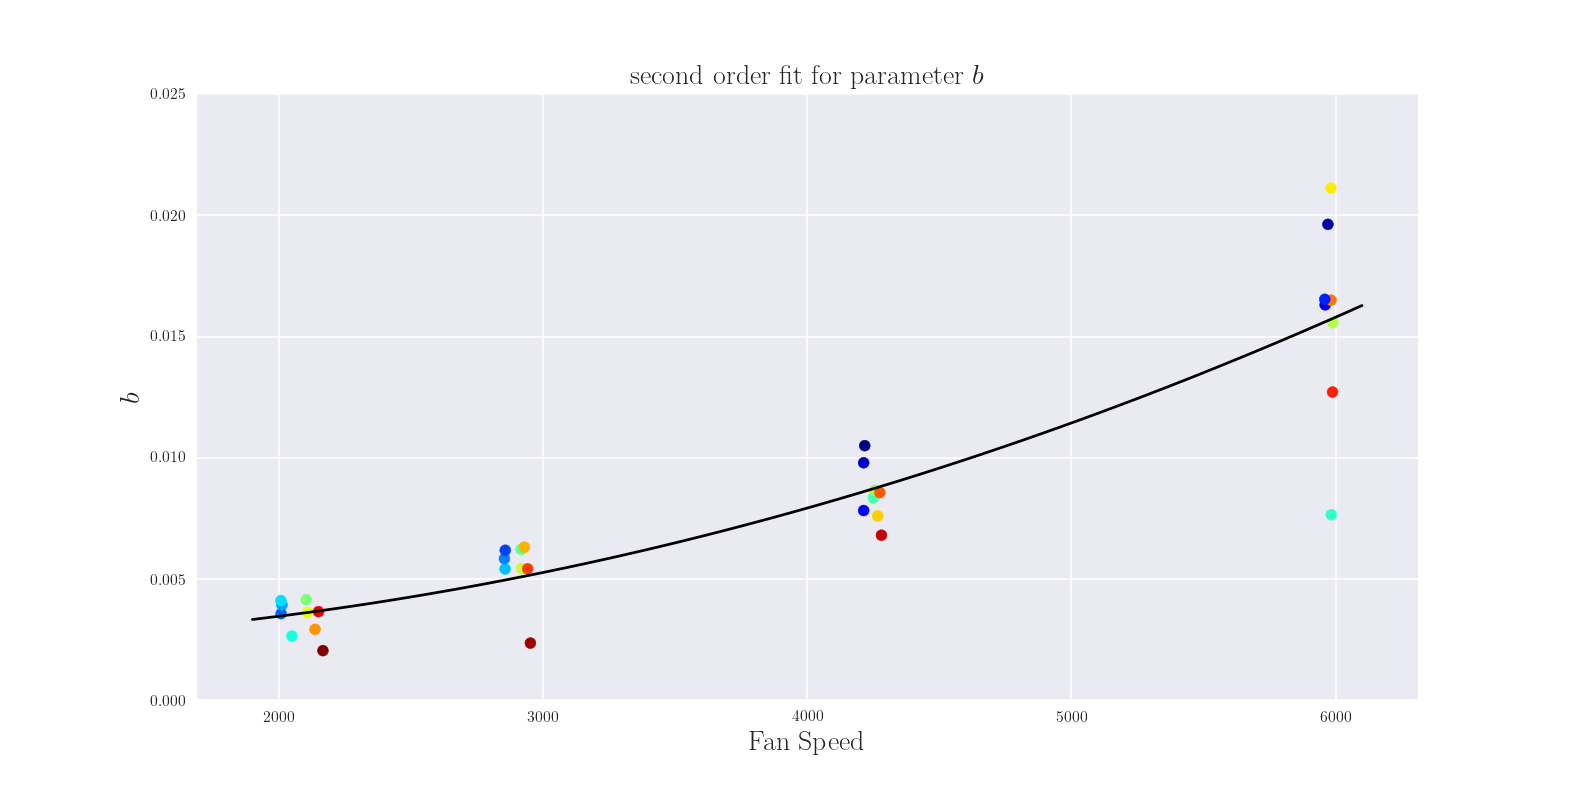

(0, 0.025)

In [356]:
X_train_b = pdCleanedData['fanspeed']
Y_train_b = pdCleanedData['b']
polybmodel = make_pipeline(PolynomialFeatures(2), Lasso(alpha=0.00005, normalize=False, max_iter=10000000))
polybmodel.fit(np.array(X_train_b).reshape(-1, 1), np.array(Y_train_b))
print("RMSE: ", mean_squared_error(Y_train_b, polybmodel.predict(np.array(X_train_b).reshape(-1, 1))))
pickle.dump(polymodel, open('b_PowerModel_polyRegr.sav', 'wb'))
fandata = np.linspace(1900,6100,100).T
plt.figure(figsize=(14,7))
plt.scatter(pdCleanedData['fanspeed'], pdCleanedData['b'], c=GetColorsCloumn(pdCleanedData['power']))
plt.plot(fandata, polybmodel.predict(fandata.reshape(-1, 1)), '-k')
plt.xlabel('Fan Speed', fontsize=18)
plt.ylabel('$b$', fontsize=18)
plt.title('second order fit for parameter $b$', fontsize=18)
plt.ylim([0,0.025])